# Assessment: Weekly deliverable template - Regression
<font color='#AC135A'>**Applied Machine Learning** - **Sheffield Hallam University**</font>


---

## Introduction
Add your solutions to the different sub-tasks requested for this deliverable.

<font color='red'>DO NOT ADD MORE CELLS TO THE FINAL VERSION OF THIS NOTEBOOK.

### 1. Dataset loading

In [1]:
import pandas as pd

df = pd.read_csv('wines_SPA.csv')

# I have done some data analysis previously, and I am aware there are also categorical variables.
# However, I understand from the grading scheme that the focus is more on the models and the evaluation 
# than on data preparation.
# Therefore, I will not perform any encoding of categorical variables at this stage.
# Neither will I impute any missing data, but simply drop rows with missing data.

# Only keep numeric columns. 
# I need to drop the categorical columns first, otherwise dropna() will also remove rows with missing data 
# in categorical columns that have no missing data in numerical columns and hence should remain.
df = df[df.select_dtypes(include=['float64', 'int64']).columns]

# Drop rows with missing data.
df = df.dropna()

# Remove duplicate rows. I noticed there were a lot of them, and they could skew the results.
df = df.drop_duplicates()

# Display the statistical summary of the dataframe.
print(df.describe())


            rating   num_reviews        price         body      acidity
count  1777.000000   1777.000000  1777.000000  1777.000000  1777.000000
mean      4.412043    544.481711   148.879392     4.258863     2.921216
std       0.151052   1380.719629   289.323828     0.652836     0.334713
min       4.200000     25.000000     4.990000     2.000000     1.000000
25%       4.300000     56.000000    33.030000     4.000000     3.000000
50%       4.400000    134.000000    58.260000     4.000000     3.000000
75%       4.500000    499.000000   125.000000     5.000000     3.000000
max       4.900000  32624.000000  3119.080000     5.000000     3.000000


**Observations:**  

The remaining dataset has 1,777 examples.

*rating*

The rating values have a range between 4.2 and 4.9. Having done some analysis previously I can say that removing the duplicates has dramatically improved the distribution of values. The 75% quartile was at 4.2 (the minimum!), and is now at 4.5. Adding/substracting the std to/from the mean shows that 68% of examples have a rating between 4.3 and 4.6, and 95% of examples have rating below 4.8. From these data I expect a reasonably good distribution at a location of 4.4, the median. Rating seems a classic target attribute, as businesses may want to predict customer rating based on a range of criteria, and indirectly (as a proxy label) sales success. I am assuming that "Quality" (from later in the sheet) refers to the "rating" variable. If used as a feature, normalisation is not necessarily required due to the moderate values, but can be done with a standard approach. 

*num_reviews*

From the name I infer that this is the number of available reviews that lead to the "rating". The range is very high between 25 and 32.624. However, the 25% and 75% quartiles are at 56 and 499, respectively. This means that 50% of examples have review numbers in this range. The location is skewed to lower values. The standard deviation is quite high though. Only 68% of examples will have review numbers below mean+std = 1890, and 95% are below mean+2*std = 3243. (I'm ignoring the bottom because the minimum value is higher than mean-std.) This suggest we definitely can see some outliers at the top end (32,624). Simply looking at the magnitudes of numbers I am thinking of a logarithmic curve. Possibly a logarithmic normalisation may be a good approach here as I expect the data to be right-skewed - as is also intuitively expected considering that only few wines will have very high numbers of ratings. 

*price*

We see similar behaviour of the price data: A huge range (4.99–3119.08), a relatively strong 25-75% range (33.015-125) that is located at the lower price range, and again a very high standard deviation that shows that only 68% of examples have a price below 438.19, while 95% have a price below 727.59. The expectation again is to have some outliers at the top end. Again for normalisation, a logarithmic approach may be indicated, maybe even when price is the label. As for correlation analysis it may be an interesting question if the price correlates to rating in some way. Also, the expectation is that the number of reviews is higher towards the lower end of the price range. 

*body*

The range for body is between 2.0 and 5.0, and we don't see any decimals. This could mean this body is likely determined as a rating between 1 and 5. the 25% quartile is at 4. This means that the more than 75% of examples has a body value of 4 or 5, i.e. one of two values. This means the informational content of this attribute is questionable.

*acidity*

For acidity the case is even more extreme: mean-2*std is at 2.25, so 95% of examples have as value 3 (the maximum value). This attribute we can ignore as there is no informational content. 

### 2. At least two exploratory graphs with captions



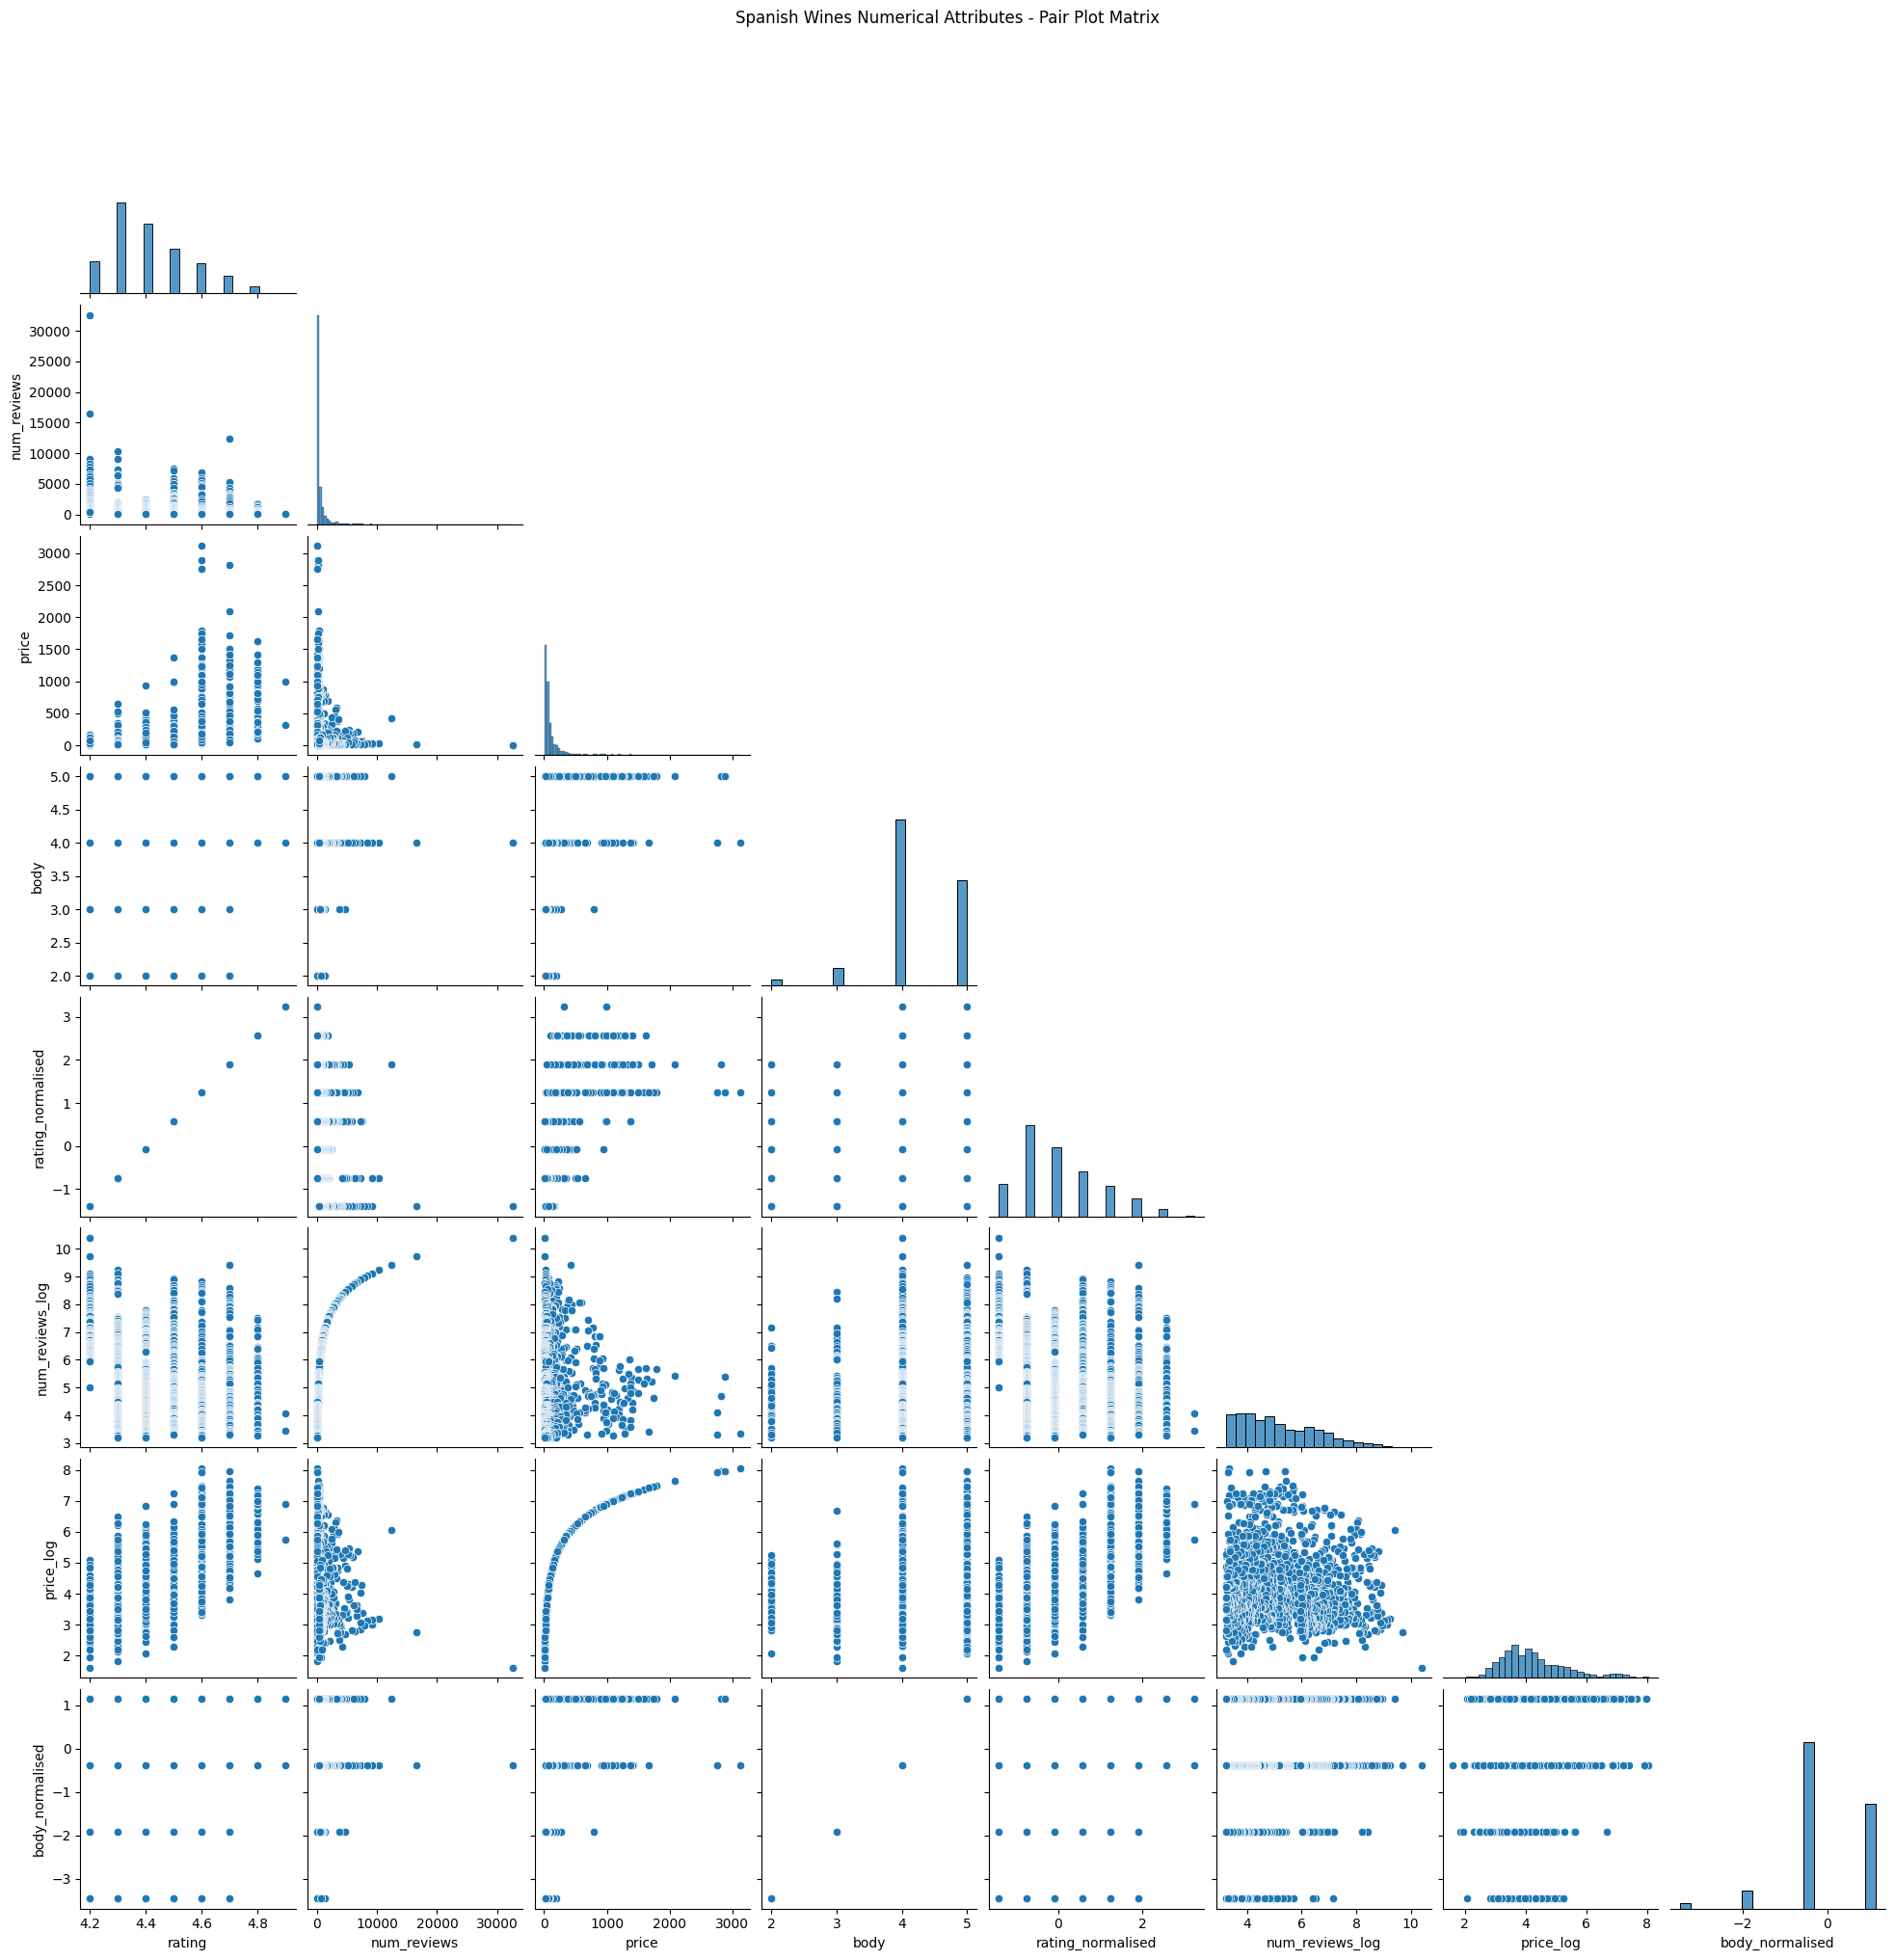

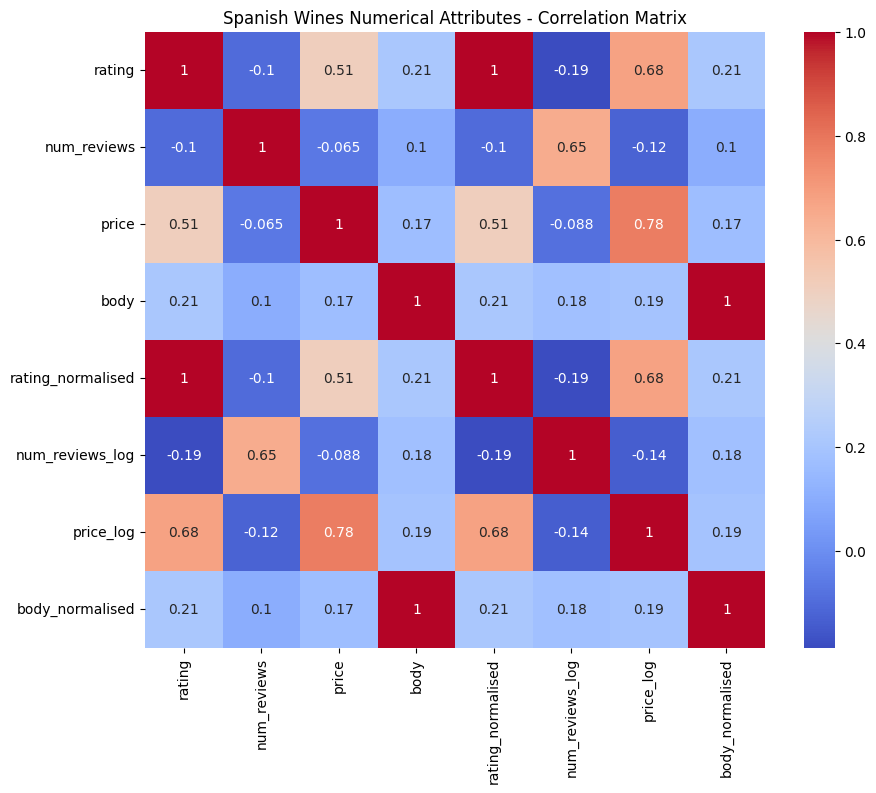

In [2]:
# drop acidity column
df = df.drop(columns=['acidity'])

# Add a normalised version of the rating column.
df['rating_normalised'] = (df['rating'] - df['rating'].mean()) / df['rating'].std()

# Add a logarithmic version of the num_reviews column.
import numpy as np
df['num_reviews_log'] = df['num_reviews'].apply(lambda x: np.log(x))

# Add a logarithmic version of the price column.
df['price_log'] = df['price'].apply(lambda x: np.log(x))

# Add a normalised version of the body column.
df['body_normalised'] = (df['body'] - df['body'].mean()) / df['body'].std()


# Show a pairplot of the dataframe.
import matplotlib.pyplot as plt
import seaborn as sns    

sns.pairplot(df,
             corner=True
             )
plt.suptitle("Spanish Wines Numerical Attributes - Pair Plot Matrix", y=1.02)
plt.show()

# Show the correlation matrix of the dataframe.
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), 
            annot=True, 
            cmap='coolwarm'
            )
plt.title("Spanish Wines Numerical Attributes - Correlation Matrix")
plt.show()

**Observations:**  

Immediately the **histograms** confirm the assumptions from the statistical data: *num_reviews* and *price* are heavily right-skewed. Rating only shows a light imbalance, which I don't find problematic as it matches the expectation in reality that most wines don't get the highest ratings. *Body* is very dominant on two values, but there is something resembling a normal distribution. However, I am still not sure how much informational content is in the value. I may test it in the module and check the respective coefficient. 

I am surprised how well the **logarithmic normalisation** works for *price* and *num_reviews*. *num_reviews_log* is  much more evenly distributed, and *price_log* has a very good normal distribution, with a small second maximum in a higher price range. I would expect if I were to look into wine types or year, this may clarify this second peak for more expensive wines. 

There are some **outliers** certainly in the *price* and *num_ratings* variables which may skew the result. I will remove the example that has > 20,000 *num_reviews*. As for *price* there seem to be 5 examples that are outliers. I could clip them or drop them. For simplicity I will drop the examples with a *price* > 2,500. 

As for the **pair plots**, *price_log* vs. *rating*/*rating_normalised* catch the eye and should give a good correlation. Other than that, nothing stands out. 

This is confirmed by the **correlation matrix**. It is interesting to see how the correlation rises between *rating* and *price* (0.51) vs. *price_log* (0.68). 

The lack of any other correlations could mean that there are no obvious dependencies between *num_reviews* and *body*, making them suitable to use as features alongside *rating* or *price*, respectively.



### 3. Histogram showing rating imbalance (if any)


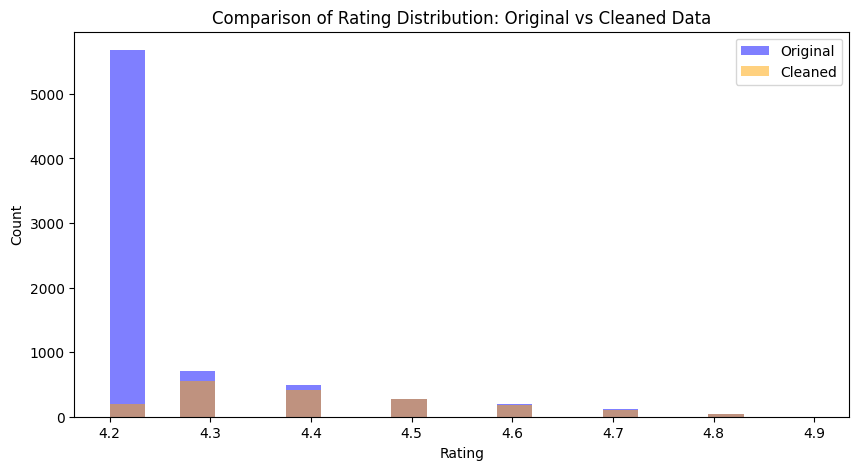

In [3]:
# I know from previous analysis that many duplicates that I removed had the same rating.
# Therefore, I want to see how the rating distribution has changed by dropping the duplicates.

# Reload the original dataframe for comparison
df_original = pd.read_csv('wines_SPA.csv')

# Compare rating between the original and the cleaned dataframe.t

plt.figure(figsize=(10,5))
plt.hist(df_original['rating'], 
         bins=20, alpha=0.5, 
         label='Original', 
         color='blue'
         )
plt.hist(df['rating'], 
         bins=20, 
         alpha=0.5, 
         label='Cleaned', 
         color='orange'
         )
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Comparison of Rating Distribution: Original vs Cleaned Data')
plt.legend()
plt.show()  

**Observations:**  

The graph shows that removing the duplicates from the dataset earlier was an essential step as it changes the *rating* distribution dramatically. 

What was originally a strongly right-skewed distribution now is a more normal distribtution, only slightly skewed to lower values as can be reasonably expected. 

It feels like the overall dataset was joined together from multiple smaller ones, and some of those datasets originally came from the same origin – but obviously that is just speculation. 

However, the cleaned up version does not require additional preparation as the distribution seems intuitively representative.

### 4. Price-regression model + metrics + plot


Linear Regression Coefficients (complex model):
           Feature  Coefficient
0  num_reviews_log    -0.013858
1        price_log     0.091982
2  body_normalised     0.015325

Complex Model Evaluation:
MAE: 0.0865
MSE: 0.0116
RMSE: 0.1077
R²: 0.4812

Linear Regression Coefficients (simple model):
     Feature  Coefficient
0  price_log     0.096739

Simple Model Evaluation:
MAE: 0.0892
MSE: 0.0120
RMSE: 0.1098
R²: 0.4610


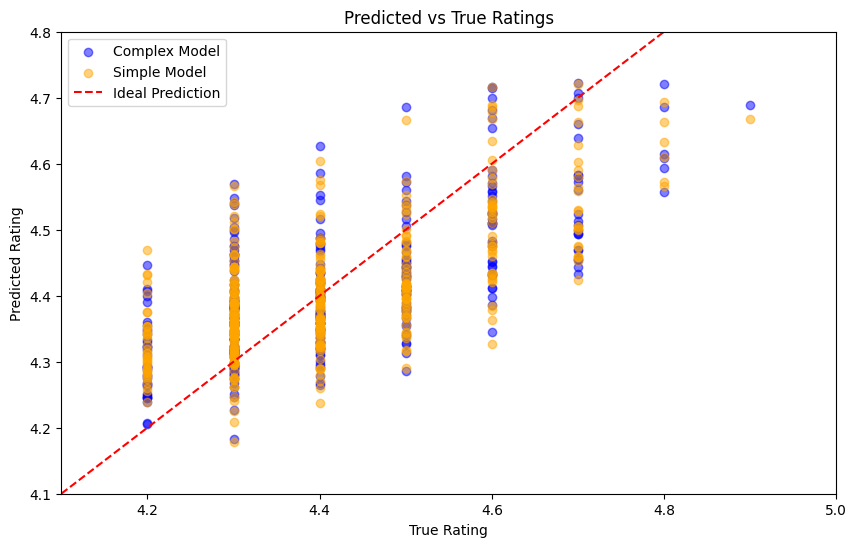

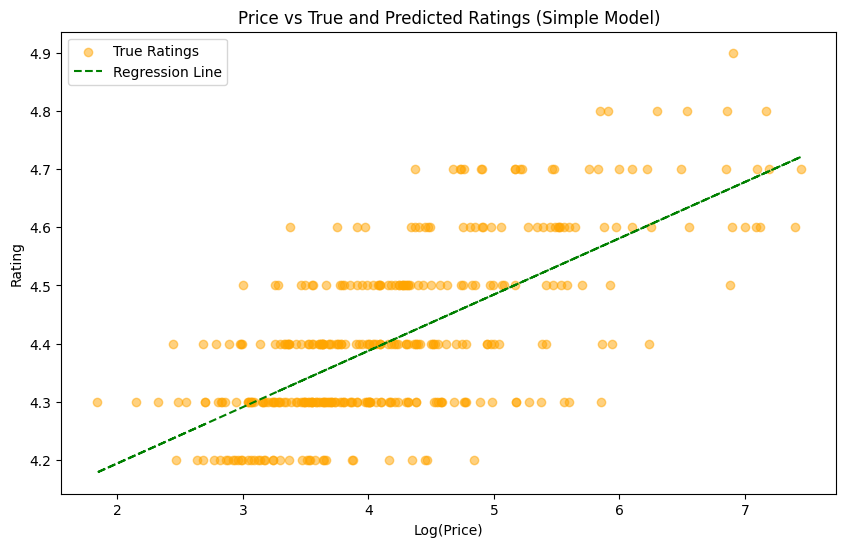

In [4]:
# Firstly, I am removing the outlier examples as previously discussed.
# That is, remove examples with num_reviews > 20000 and price > 2500.   
df = df[(df['num_reviews'] <= 20000) & (df['price'] <= 2500)]

# Now I can start building models.
# I will use 80% of the data for training and 20% for testing.
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=1)
# I will first use the following features for prediction to build a model with multiple features:
features_complex = ['num_reviews_log', 'price_log', 'body_normalised']
# I will predict the following target
# (I do not need to normalise the target as the values are already in a moderate range):
target = 'rating'

# I will use the following regression model:
from sklearn.linear_model import LinearRegression
lr_complex = LinearRegression()
# Train the model
lr_complex.fit(train_df[features_complex], train_df[target])
# Predict on the test set
predictions_complex = lr_complex.predict(test_df[features_complex])

# Evaluation
# I want to understand the coefficients of the linear regression model.
coefficients_complex = pd.DataFrame({'Feature': features_complex,
                             'Coefficient': lr_complex.coef_
                             })
print("Linear Regression Coefficients (complex model):")
print(coefficients_complex)

# I will use the following metrics for evaluation:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_complex = mean_absolute_error(test_df[target], predictions_complex)
mse_complex = mean_squared_error(test_df[target], predictions_complex)
rmse_complex = np.sqrt(mse_complex)
r2_complex = r2_score(test_df[target], predictions_complex) 
print(f"\nComplex Model Evaluation:\nMAE: {mae_complex:.4f}\nMSE: {mse_complex:.4f}\nRMSE: {rmse_complex:.4f}\nR²: {r2_complex:.4f}") 


# I am expecting price to be the most influential feature, based on the correlation matrix.
# I will also build a simpler model with only price as feature to compare the results.
features_simple = ['price_log']
lr_simple = LinearRegression()
# Train the model   
lr_simple.fit(train_df[features_simple], train_df[target])
# Predict on the test set
predictions_simple = lr_simple.predict(test_df[features_simple])    
# Coefficients
coefficients_simple = pd.DataFrame({'Feature': features_simple,
                             'Coefficient': lr_simple.coef_
                             })
print("\nLinear Regression Coefficients (simple model):")
print(coefficients_simple)
# Evaluation
mae_simple = mean_absolute_error(test_df[target], predictions_simple)
mse_simple = mean_squared_error(test_df[target], predictions_simple)
rmse_simple = np.sqrt(mse_simple)
r2_simple = r2_score(test_df[target], predictions_simple)
print(f"\nSimple Model Evaluation:\nMAE: {mae_simple:.4f}\nMSE: {mse_simple:.4f}\nRMSE: {rmse_simple:.4f}\nR²: {r2_simple:.4f}")


# I now viualise the predictions against the true values for both models in different colors.
plt.figure(figsize=(10, 6))
# Scatter plot of true vs predicted values for both models
plt.scatter(test_df[target], predictions_complex, color='blue', alpha=0.5, label='Complex Model')
plt.scatter(test_df[target], predictions_simple, color='orange', alpha=0.5, label='Simple Model')
# Plot the ideal line (where predicted = true value)    
plt.plot([4.1, 5], [4.1, 5], color='red', linestyle='--', label='Ideal Prediction')
# Labels and title
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Ratings')
plt.legend()
plt.xlim(4.1, 5)
plt.ylim(4.1, 4.8)
plt.show()


# For the simple model, I also want to see how the rating predictions differ from the actuals.
plt.figure(figsize=(10, 6))
# Scatter plot of price_log vs true rating
plt.scatter(test_df['price_log'], test_df[target], color='orange', alpha=0.5, label='True Ratings')
# Plot the regression line
plt.plot(test_df['price_log'], predictions_simple, color='green', linestyle='--', label='Regression Line')
# Labels and title
plt.xlabel('Log(Price)')
plt.ylabel('Rating')
plt.title('Price vs True and Predicted Ratings (Simple Model)')
plt.legend()
plt.show()


**Observations:**  

The **coefficients** in the more complex model meet the expectations:
- *num_reviews_log* correlates negatively with *rating*. That means, a change of magnitude in number of reviews only influences the rating by 0.014. That is not very much, considering *num_reviews_log* only has a range between 3 and 10, so a drop of num_reviews_log from max to min (before dropping the outliner!) would result in the increase of one rating decimal, e.g. 4.2 to 4.3. 
- *price_log* is as expected the most influential. A magnitude change in price changes the rating by almost one decimal. Even after dropping the outliers the price_log range is still rougly between 1 and 8, which would be cover the entire range of ratings (4.2–4.9)
- *body_normalised*, like *num_reviews_log*, as a very small influence given the limited range and the small coefficient. 

The **evaluation measures** are showing the following:
In both the complex and the simpler model, MAE and RMSE are both rougly around 0.1 which means the rating can be expected to be off on average by +/–0.1. Considering the range is only 4.2–4.9, this is not very precise. 
R-squared shows that only 48% of the rating variance in the more complex and 46% in the simpler model can be explained with these models. This is not very good either. 
Overall, the complex model performs a little bit better than the simple model, but not significantly. For the sake of simplicity, I would go with the simpler model (i.e. only use *price_log* as feature)

The first **visualisation** compares both models and confirms that there is no major difference. Notably, the range of predicted ratings does not span the entire range up to 4.9, but only goes up to 4.75. Visually, it looks like the predictions are generally too high in the lower ratings (4.2, 4.3), but too low in the higher ratings (4.5–4.9).

The second visualisation shows price vs rating with the actual regression line based on the simple model (only *price_log* feature). The plot confirms what was observed in the first visalisation: Wines with lower actual ratings tend to be overpredicted based on *price_log*, while wines with higher ratings tend to be underpredicted.

### 5. Quality-regression model + metrics + plot


In [5]:
# Now reverse the model to predict price from rating.
# I will keep price_log as target, as price is strongly right-skewed and has large values.
features_reverse = ['rating']
target_reverse = 'price_log'
lr_reverse = LinearRegression()
# Train the model
lr_reverse.fit(train_df[features_reverse], train_df[target_reverse])
# Predict on the test set
predictions_reverse = lr_reverse.predict(test_df[features_reverse])
# Coefficients
coefficients_reverse = pd.DataFrame({'Feature': features_reverse,
                             'Coefficient': lr_reverse.coef_
                             })
print("\nLinear Regression Coefficients (reverse model):")
print(coefficients_reverse)
# Evaluation
mae_reverse = mean_absolute_error(test_df[target_reverse], predictions_reverse)
mse_reverse = mean_squared_error(test_df[target_reverse], predictions_reverse)
rmse_reverse = np.sqrt(mse_reverse)
r2_reverse = r2_score(test_df[target_reverse], predictions_reverse)
print(f"\nReverse Model Evaluation:\nMAE: {mae_reverse:.4f}\nMSE: {mse_reverse:.4f}\nRMSE: {rmse_reverse:.4f}\nR²: {r2_reverse:.4f}")   


Linear Regression Coefficients (reverse model):
  Feature  Coefficient
0  rating     4.702434

Reverse Model Evaluation:
MAE: 0.6015
MSE: 0.5876
RMSE: 0.7666
R²: 0.4604


**Observations:**  

### 6. Over/under-fitting discussion and fix

In [6]:
# ---- Your code here ----

**Observations:**  

### 7. Apply cross-validation or statistical analyses on the features or results of the regression models (advanced)

In [7]:
# ---- Your code here ----

**Observations:**  